# Physics 3: Blackhole

In [130]:
import torch
from kan import *
from kan.utils import batch_jacobian
from kan.MLP import MLP

torch.use_deterministic_algorithms(True)
torch.set_default_dtype(torch.float64)

#model = KAN(width=[1,5,5,1], grid=5, grid_range=[1.2,3], grid_eps=0.)
#model = KAN(width=[1,1], grid=1, grid_range=[1.2,3], grid_eps=0., base_fun='zero')
#model.speed()
model = MLP(width=[1,20,20,1])

#model = lambda x: 2 * torch.sqrt(x) + torch.log((torch.sqrt(x)-1)/(torch.sqrt(x)+1))

# Schwarzschild 2M = 1
def g(x_):
    bs = x_.shape[0]
    t = x_[:,0]
    a = torch.ones_like(t)
    x = x_[:,1]
    y = x_[:,2]
    z = x_[:,3]
    r = torch.sqrt(x**2+y**2+z**2)
    stack1 = torch.stack([torch.ones(bs,)-1/r, torch.zeros(bs,), torch.zeros(bs,), torch.zeros(bs,)])
    stack2 = torch.stack([torch.zeros(bs,), -(1+x**2/((r-1)*r**2)), -x*y/((r-1)*r**2), -x*z/((r-1)*r**2)])
    stack3 = torch.stack([torch.zeros(bs,), -x*y/((r-1)*r**2), -(1+y**2/((r-1)*r**2)), -y*z/((r-1)*r**2)])
    stack4 = torch.stack([torch.zeros(bs,), -x*z/((r-1)*r**2), -y*z/((r-1)*r**2), -(1+z**2/((r-1)*r**2))])
    gs = torch.stack([stack1, stack2, stack3, stack4]).permute(2,0,1)
    return gs

def transform_g(transform, g, x):
    jac = batch_jacobian(transform, x, create_graph=True, mode='vector')
    jac_inv = torch.inverse(jac)
    return torch.matmul(torch.matmul(jac_inv.permute(0,2,1), g(x)),jac_inv)

def transform(x):
    t = x[:,[0]]
    r = torch.linalg.norm(x[:,1:], dim=1, keepdim=True)
    tp = t + model(r)
    #u = torch.sqrt(r)
    #tp = t - (2*u+torch.log((u-1)/(u+1)))
    return torch.cat([tp, x[:,1:]], dim=1)


In [131]:
from kan import *
from kan.utils import batch_jacobian, create_dataset_from_data
import numpy as np


steps = 5
log = 1
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
#optimizer = torch.optim.Adam([], lr=1e-3)
pbar = tqdm(range(steps), desc='description', ncols=100)

n_train = 10000
W = torch.normal(0,1,size=(n_train,4))
input_ = torch.empty(n_train,4, requires_grad=False)
input_[:,0] = torch.rand(n_train, requires_grad=True)
#rs = 1.2 + 1.8 * torch.linspace(0,1,n_train)
rs = 1.2 + 1.8 * torch.linspace(0,1,n_train)
input_[:,1:] = W[:,1:]/torch.norm(W[:,1:], dim=1, keepdim=True)*torch.unsqueeze(rs, dim=1)
x = input_.detach().requires_grad_(True)

def closure():
    
    global loss
    global x
    optimizer.zero_grad()
    
    g_GP = transform_g(transform, g, x)
    num = x.shape[0]
    loss = torch.mean((g_GP[:,1:,1:] + torch.eye(3,3)[None,:,:].expand(num,3,3))**2)

    loss.backward()
    return loss

for _ in pbar:
        
    '''if _ < 50 and _ % 5 == 0:
        model.update_grid(x)'''
        
    optimizer.step(closure)
    
    if _ % log == 0:
        pbar.set_description("| loss: %.2e |" % loss.cpu().detach().numpy())
        
        

| loss: 1.05e-04 |: 100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.42s/it]


In [62]:
model = model.refine(20)

saving model version 0.1


Text(1.5, -23.3, '$-(2\\sqrt{r}+{\\rm log}(\\frac{\\sqrt{r}-1}{\\sqrt{r}+1}))+C$')

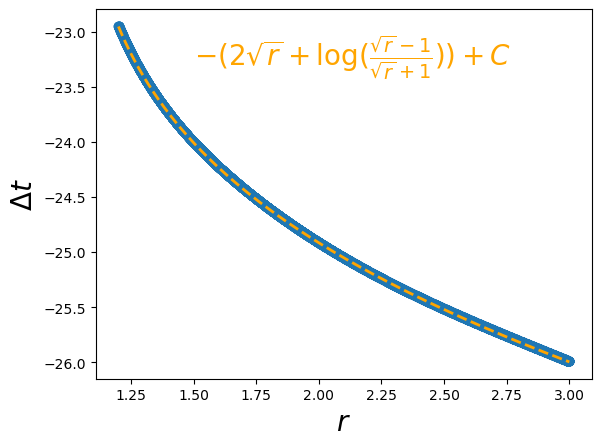

In [146]:
plt.scatter(rs.detach().numpy(), model(rs[:,None])[:,0].detach().numpy())
u = torch.sqrt(rs)
dt = 2*u + torch.log((u-1)/(u+1))
#plt.plot(rs, dt+3.65, color='red', ls='--', lw=2)
plt.plot(rs, -dt-23.85, color='orange', ls='--', lw=2)
plt.xlabel(r'$r$', fontsize=20)
plt.ylabel(r'$\Delta t$', fontsize=20)
#plt.text(1.5,3,r'$2\sqrt{r}+{\rm log}(\frac{\sqrt{r}-1}{\sqrt{r}+1})+C_1$',color='red',fontsize=20)
plt.text(1.5,-23.3,r'$-(2\sqrt{r}+{\rm log}(\frac{\sqrt{r}-1}{\sqrt{r}+1}))+C$',color='orange',fontsize=20)

Text(1.5, 7, '$-(2\\sqrt{r}+{\\rm log}(\\frac{\\sqrt{r}-1}{\\sqrt{r}+1}))+C_2$')

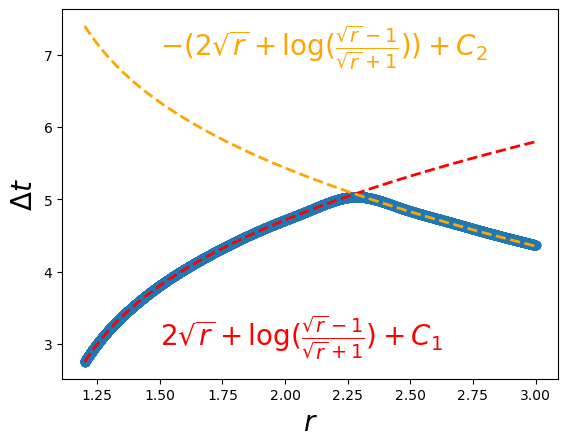

In [129]:
plt.scatter(rs.detach().numpy(), model(rs[:,None])[:,0].detach().numpy())
u = torch.sqrt(rs)
dt = 2*u + torch.log((u-1)/(u+1))
plt.plot(rs, dt+3.65, color='red', ls='--', lw=2)
plt.plot(rs, -dt+6.5, color='orange', ls='--', lw=2)
plt.xlabel(r'$r$', fontsize=20)
plt.ylabel(r'$\Delta t$', fontsize=20)
plt.text(1.5,3,r'$2\sqrt{r}+{\rm log}(\frac{\sqrt{r}-1}{\sqrt{r}+1})+C_1$',color='red',fontsize=20)
plt.text(1.5,7,r'$-(2\sqrt{r}+{\rm log}(\frac{\sqrt{r}-1}{\sqrt{r}+1}))+C_2$',color='orange',fontsize=20)

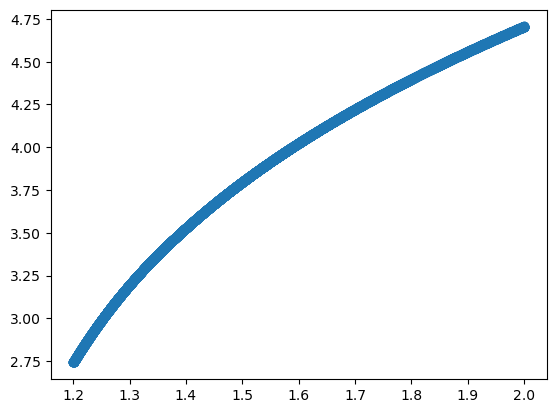

In [40]:
plt.scatter(rs.detach().numpy(), model(rs[:,None])[:,0].detach().numpy())

In [68]:
g_GP = transform_g(transform, g, x)
num = x.shape[0]
loss = torch.mean((g_GP[:,1:,1:] + torch.eye(3,3)[None,:,:].expand(num,3,3))**2, dim=[1,2])

In [69]:
loss

tensor([2.4633e-03, 2.4056e-03, 2.3489e-03,  ..., 5.6274e-05, 5.7003e-05,
        5.7739e-05], grad_fn=<MeanBackward1>)

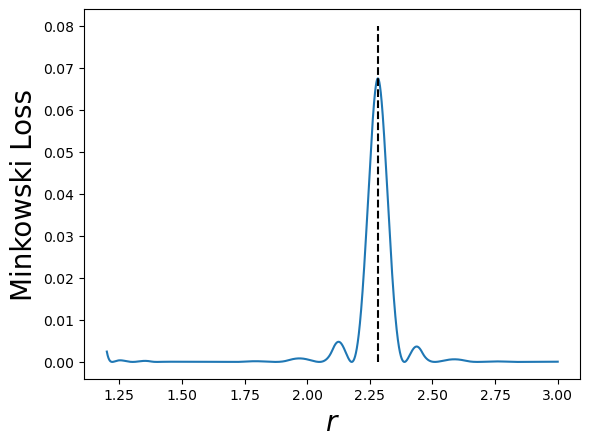

In [123]:
plt.plot(rs.detach().numpy(), loss.detach().numpy())
plt.xlabel(r'$r$', fontsize=20)
plt.ylabel('Minkowski Loss', fontsize=20)
plt.plot([2.282,2.282],[0,0.08], ls='--', color='black')